In [1]:
import pandas as pd 
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns   
from scipy.stats import norm
import gstools as gs
from gstools import SRF, Exponential, Matern, Gaussian

sns.set_palette('colorblind')
sns.set_style()

# Representative 1D Vs profile

In [2]:
import numpy as np
from scipy.stats import qmc

def generate_data(num_models, Vs_soil_range=(np.log10(100),np.log10(360)), Vs_bedrock_range=(np.log10(760), np.log10(1500)), n_Vs = 1000, h_range=(1, 29)):

    models = []  # Initialize arrays list

    sampler = qmc.LatinHypercube(d=2) # Create a Latin Hypercube Sampler with 3 dimensions

    lower_bound = [Vs_soil_range[0], Vs_bedrock_range[0]] # Lower bound for the sampler
    upper_bound = [Vs_soil_range[1], Vs_bedrock_range[1],] # Upper bound for the sampler

    scaled_samples = qmc.scale(sampler.random(n_Vs), lower_bound, upper_bound) # Generate n_Vs samples

    # Integer sampling
    sampler = qmc.LatinHypercube(d=1) # Create a Latin Hypercube Sampler with 1 dimension
    h_soil_array = sampler.integers(l_bounds=h_range[0], u_bounds=h_range[1]+1, n=n_Vs, endpoint=True) # Generate n_Vs samples

    # Uniformly sample the height of the soil layer
    #h_soil_array = rng.integers(h_range[0], h_range[1]+1, size=num_models, endpoint=True)

    for i in range(num_models): # Loop over the number of models
        Vs_s, Vs_b = scaled_samples[i]
        #Vs_s, Vs_b = scaled_samples[i]
        h_soil = h_soil_array[i]
        # Un log the Vs values
        Vs_s = 10**Vs_s
        Vs_b = 10**Vs_b
        #h_soil = int(h_soil)
        # Creation of the array
        soil_array = np.full(h_soil, Vs_s) # Generate an array of Vs_s values
        bedrock_array = np.array([Vs_b]) # Generate an array of Vs_b values
        array = np.concatenate([soil_array, bedrock_array]) # Concatenate the two arrays
        models.append(array) # Append the array to the list

    return models

# Example usage
A = generate_data(1000)

# Mean height of the soil layer
avg_len = 0
for a in A:
    avg_len += len(a)
avg_len /= len(A)
print(avg_len, avg_len*5)

Vs_soil = []
Vs_bedrock = []
h = []
for a in A:
    Vs_soil.append(np.mean(a[:-1]))
    Vs_bedrock.append(a[-1])
    h.append((len(a)-1)*5)


16.5 82.5


## Spatial variability

### Defining intra variability

In [3]:
Vs_try = A[0][:-1]
print(Vs_try)
# Define seed
np.random.seed(0)

[252.79921746 252.79921746 252.79921746 252.79921746 252.79921746
 252.79921746 252.79921746 252.79921746 252.79921746 252.79921746
 252.79921746 252.79921746 252.79921746 252.79921746 252.79921746
 252.79921746 252.79921746 252.79921746 252.79921746 252.79921746
 252.79921746 252.79921746 252.79921746]


In [4]:
# Defining a grid of 10 x 10 meters
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

# Assuming the following: 
## Exponential distribution
rH = 50
a_HV = 100
rV = rH / a_HV

desired_mean = Vs_try[0]
desired_variance = 0.5

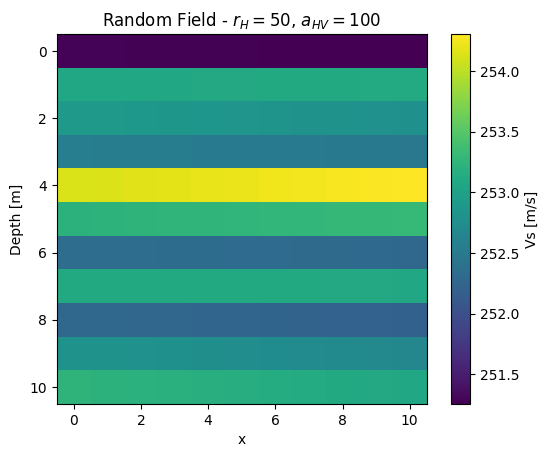

In [5]:
# Calculate the distance between the points
model = gs.Exponential(dim=2, var=1, len_scale = rH, anis=a_HV)
srf = gs.SRF(model)

field = srf.structured([x, y])
# Scale the random field to the desired mean and variance
scaled_field = (field - np.mean(field)) / np.std(field) * np.sqrt(desired_variance) + desired_mean

# Transform the scaled random field to a lognormal distribution


# Plot the lognormal random field
plt.imshow(scaled_field, origin='lower')
plt.xlabel('x')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.title(rf'Random Field - $r_H = {rH}$, $a_{{HV}} = {a_HV}$')
plt.colorbar(label='Vs [m/s]')
plt.show()


## Doing the model developed by Yang et al 2022

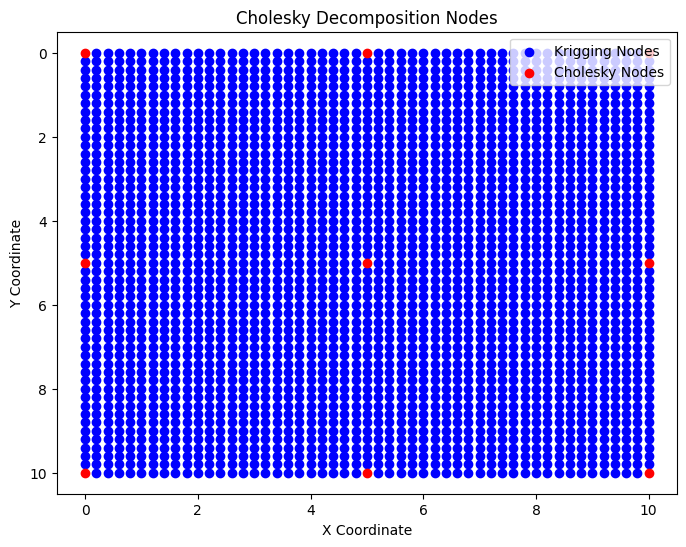

In [6]:
# Defining a mesh
x = np.linspace(0, 10, 51)
y = np.linspace(0, 10, 51)

X, Y = np.meshgrid(x, y)

# Defining the Cholesky nodes as any multiple of 5
x_chol = np.linspace(0, 10, 3)
y_chol = np.linspace(0, 10, 3)

X_chol, Y_chol = np.meshgrid(x_chol, y_chol)
X_chol = X_chol.flatten()
Y_chol = Y_chol.flatten()

# Filtering out the Cholesky nodes
mask = np.ones(X.shape, dtype=bool)
for xc, yc in zip(X_chol, Y_chol):
    mask &= ~((X == xc) & (Y == yc))

X_filtered = X[mask]
Y_filtered = Y[mask]

# Plotting the mesh
plt.figure(figsize=(8, 6))
plt.scatter(X_filtered, Y_filtered, color='blue', label='Krigging Nodes')
plt.scatter(X_chol, Y_chol, color='red', label='Cholesky Nodes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()
plt.title('Cholesky Decomposition Nodes')
plt.legend()
plt.show()

In [7]:
# Transform the x coordinates 
transform_eq_6 = lambda x: x/a_HV
transform_eq_6 = np.vectorize(transform_eq_6)

In [8]:
def exp_cov(x, y, rH, rV):
    rho = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            tau_x = np.abs(x[i] - x[j])
            tau_y = np.abs(y[i] - y[j])
            rho[i, j] = np.exp(-2*(tau_x/rH + tau_y/rV))
    return rho

In [9]:
# Calculate the distance between the points
rho_chol = exp_cov(transform_eq_6(X_chol), Y_chol, rH, rV)

# Decompose the covariance matrix
L = np.linalg.cholesky(rho_chol)

# Standard normal random field
G_chol = L @ np.random.normal(0, 1, len(Y_chol))

In [10]:
# Calculate C chol, krig
rho_chol_krig = np.zeros((len(X_chol), len(X_filtered)))

for i in range(len(X_chol)):
    for j in range(len(X_filtered)):
        tau_x = np.abs(X_chol[i] - X_filtered[j])
        tau_y = np.abs(Y_chol[i] - Y_filtered[j])
        rho_chol_krig[i, j] = np.exp(-2*(tau_x/rH + tau_y/rV))

In [11]:
# Compute the matrix
ones_column = np.ones((len(rho_chol), 1))
A_mat = np.hstack((rho_chol, ones_column))
A_mat = np.vstack((A_mat, np.append(np.ones((1, len(rho_chol))), 0)))

# Compute the right hand side
b = np.vstack((rho_chol_krig, np.ones((1, rho_chol_krig.shape[1]))))

In [12]:
W = np.linalg.solve(A_mat, b)[:-1,:]
Y_krig = W.T @ G_chol

In [13]:
# Reorder G_chol and Y_krig to match the grid
G_overall = np.zeros((len(X), len(Y)))

# Place G_chol values into the overall grid
for i, (xc, yc) in enumerate(zip(X_chol, Y_chol)):
    idx = np.where((X == xc) & (Y == yc))
    G_overall[idx] = G_chol[i]

# Place Y_krig values into the overall grid
for i, (xf, yf) in enumerate(zip(X_filtered, Y_filtered)):
    idx = np.where((X == xf) & (Y == yf))
    G_overall[idx] = Y_krig[i]


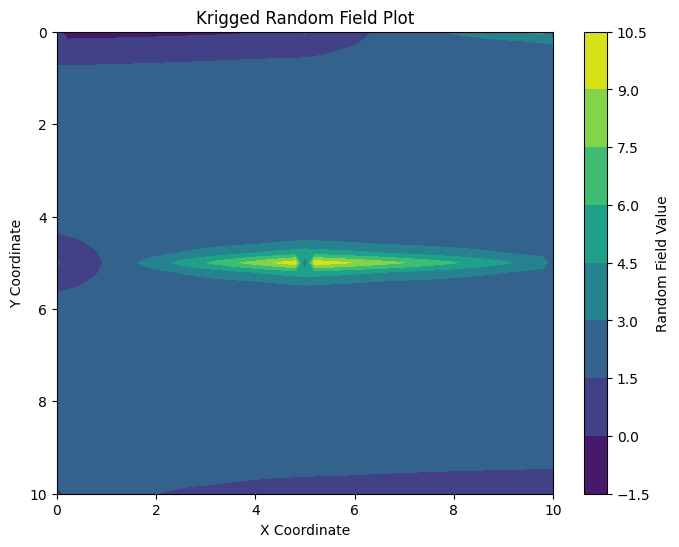

In [14]:
# Plot G_overall
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, G_overall, cmap='viridis')
plt.colorbar(label='Random Field Value')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Krigged Random Field Plot')
plt.gca().invert_yaxis()
plt.show()

## Transition zones

Conditional random field

# Define the area

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100.]


c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\gstools\field\plot.py:111: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


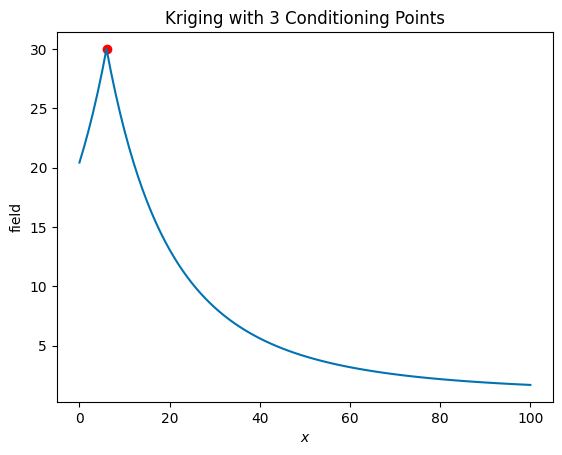

In [15]:
x = np.linspace(0,100,101)
print(x)
rH = 50
a_HV = 10

# Conditional positions
cond_pos = [6]
cond_val = [30]

# Gstools
model = gs.Exponential(dim=1, var=1, len_scale = rH, anis=1/a_HV)
normalizer = gs.normalizer.LogNormal
kridge = gs.krige.Simple(model, cond_pos, cond_val, normalizer=normalizer)

kridge(x)
ax =kridge.plot()
ax.scatter(cond_pos, cond_val, color='red', label='Conditioning Points')
ax.set_title('Kriging with 3 Conditioning Points')
plt.show()

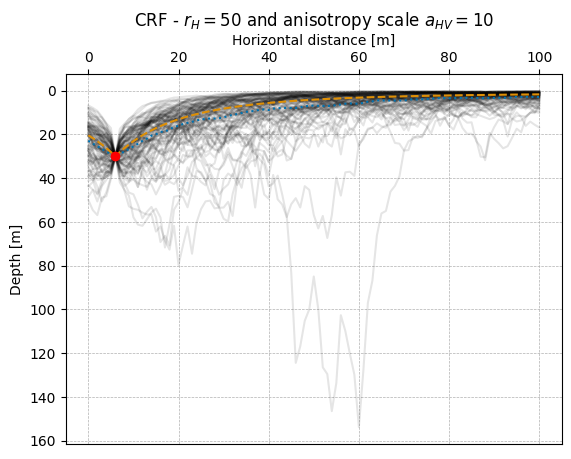

In [16]:
cond_srf = gs.CondSRF(krige=kridge)
cond_srf.set_pos(x)

seed = gs.random.MasterRNG(20170519)
for i in range(100):
    cond_srf(seed=seed(), store=f"f{i}")
    label = "Conditioned ensemble" if i == 0 else None
    plt.plot(x, cond_srf[f"f{i}"], color="k", alpha=0.1, label=label)

fields = [cond_srf[f"f{i}"] for i in range(100)]
plt.plot(x, np.mean(fields, axis=0), linestyle=":", label="Ensemble mean")
plt.plot(x, cond_srf.krige.field, linestyle="dashed", label="Kriged field")
plt.scatter(cond_pos, cond_val, zorder=10, label="Conditions", color='red')

plt.gca().invert_yaxis()

plt.title(rf"CRF - $r_H = {rH}$ and anisotropy scale $a_{{HV}} = {a_HV}$")
plt.xlabel("Horizontal distance [m]")
plt.ylabel("Depth [m]")

# Put horizontal label and ticks on top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# Grid 1x1
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

In [17]:
# Take one of the fields
field_depth = cond_srf[f"f50"]
# Round to nearest integer
field_depth = np.round(field_depth)

In [18]:
x = np.linspace(0, 100, 101)
y = np.linspace(0, 50, 51)

_, Y = np.meshgrid(x, y)

model = gs.Exponential(dim=2, var=1, len_scale = rH, anis=a_HV)
srf = gs.SRF(model)

field = srf.structured([x, y])

# Scale the random field to the desired mean and variance
desired_mean = Vs_try[0]
desired_variance = 5000

scaled_field = (field - np.mean(field)) / np.std(field) * np.sqrt(desired_variance) + desired_mean

In [19]:
# Masking
mask = Y > field_depth
masked_field = np.ma.masked_where(mask.T, scaled_field)

In [20]:
field_depth

array([37., 36., 36., 34., 34., 31., 30., 31., 28., 26., 24., 21., 18.,
       16., 12., 12., 12., 11., 12., 11., 10., 10.,  9.,  8.,  7.,  7.,
        7.,  7.,  6.,  6.,  5.,  5.,  3.,  3.,  3.,  2.,  2.,  2.,  1.,
        1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  3.,  2.,  2.,  2.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,
        1.,  2.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  3.,  4.,
        3.,  4.,  4.,  3.,  3.,  3.,  4.,  5.,  5.,  5.,  5.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  3.,  2.])

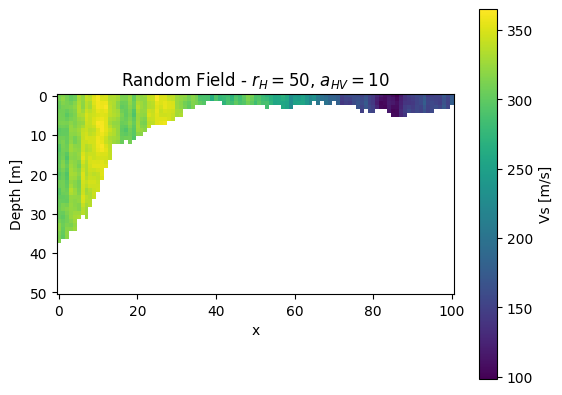

In [21]:
# Plot
plt.imshow(masked_field.T, origin='lower')
plt.xlabel('x')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.title(rf'Random Field - $r_H = {rH}$, $a_{{HV}} = {a_HV}$')
plt.colorbar(label='Vs [m/s]')
plt.gca()
plt.show()

In [22]:
masked_field = masked_field.filled(A[0][-1])

In [23]:
masked_field.shape

(101, 51)

[86 85 94]


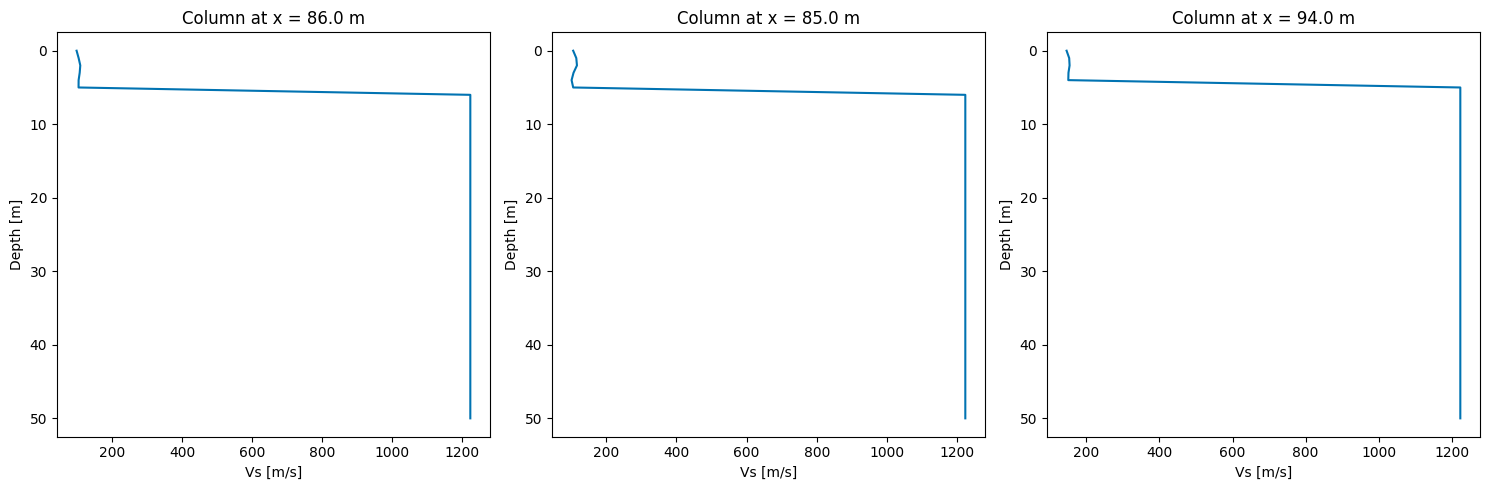

In [24]:
# Select randomly 3 columns of the field
columns = np.random.choice(masked_field.shape[0], 3, replace=False)
print(columns)

# Plot the columns
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(columns):
    ax[i].plot(masked_field[col,:], y)
    ax[i].set_xlabel('Vs [m/s]')
    ax[i].set_ylabel('Depth [m]')
    ax[i].set_title(f'Column at x = {x[col]} m')
    ax[i].invert_yaxis()
plt.tight_layout()
plt.show()